In [1]:
### ACTIONS YOU NEED TO DO ###
# Comments related to the code #


### Make sure to run all cells at the start ###

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import datetime
from datetime import timedelta
from sklearn.metrics import mean_squared_error

In [2]:
# importing relevant station files #
from google.colab import files
data_to_load = files.upload()

### Press choose file, then select the file you want ###

Saving Alexander_Lake_1267_clean.csv to Alexander_Lake_1267_clean.csv


In [3]:
import io

### Change below to the filename you need. Not the location, just the name ###
df = pd.read_csv(io.BytesIO(data_to_load['Alexander_Lake_1267_clean.csv']))
### Change the station name and number below ###
station_name = 'Alexander Lake (1267)'
column_name = station_name + ' Snow Depth (cm) Start of Day Values'

In [4]:
df = df.dropna()

df.head()

,Date,Alexander Lake (1267) Air Temperature Minimum (degC),Alexander Lake (1267) Air Temperature Average (degC),Alexander Lake (1267) Air Temperature Maximum (degC),Alexander Lake (1267) Precipitation Accumulation (mm) Start of Day Values,Alexander Lake (1267) Precipitation Increment - Snow-adj (mm),Alexander Lake (1267) Snow Depth (cm) Start of Day Values,Alexander Lake (1267) Snow Density (pct) Start of Day Values
0,2014-10-31,-6.132089,-3.094423,-0.462351,87.133585,1.747945,11.525486,13.294140
1,2014-11-01,-6.199359,-3.164653,-0.553671,88.679944,1.769662,12.136748,13.442437
2,2014-11-02,-6.269141,-3.235974,-0.644023,90.245465,1.790356,12.759021,13.595702
3,2014-11-03,-6.341910,-3.308689,-0.733584,91.829373,1.809832,13.391078,13.753767
4,2014-11-04,-6.418120,-3.383106,-0.822548,93.430704,1.827982,14.031640,13.916430


In [60]:
from sklearn.preprocessing import MinMaxScaler

## 1 month .shift(-30) below
sc1 = MinMaxScaler(feature_range = (0, 1))
temp = df[['Date', station_name + ' Air Temperature Minimum (degC)', station_name + ' Air Temperature Average (degC)', station_name + ' Air Temperature Maximum (degC)', station_name + ' Precipitation Accumulation (mm) Start of Day Values']]
temp[column_name] = (df.loc[:,column_name]).shift(-365)
temp = temp.dropna()
Xs1 = temp.drop('Date', axis=1)
Xs1 = sc1.fit_transform(Xs1)
## 3 months .shift(-91) below
sc2 = MinMaxScaler(feature_range = (0, 1))
Xs2 = df[[station_name + ' Air Temperature Minimum (degC)', station_name + ' Air Temperature Average (degC)', station_name + ' Air Temperature Maximum (degC)', station_name + ' Precipitation Accumulation (mm) Start of Day Values']]
Xs2[column_name] = (df.loc[:,column_name]).shift(-730)
Xs2 = Xs2.dropna()
Xs2 = sc2.fit_transform(Xs2)
## 6 months .shift(-182) below
sc3 = MinMaxScaler(feature_range = (0, 1))
Xs3 = df[[station_name + ' Air Temperature Minimum (degC)', station_name + ' Air Temperature Average (degC)', station_name + ' Air Temperature Maximum (degC)', station_name + ' Precipitation Accumulation (mm) Start of Day Values']]
Xs3[column_name] = (df.loc[:,column_name]).shift(-1096)
Xs3 = Xs3.dropna()
Xs3 = sc3.fit_transform(Xs3)
## 12 months .shift(-365) below
sc4 = MinMaxScaler(feature_range = (0, 1))
Xs4 = df[[station_name + ' Air Temperature Minimum (degC)', station_name + ' Air Temperature Average (degC)', station_name + ' Air Temperature Maximum (degC)', station_name + ' Precipitation Accumulation (mm) Start of Day Values']]
Xs4[column_name] = (df.loc[:,column_name]).shift(-1461)
Xs4 = Xs4.dropna()
Xs4 = sc4.fit_transform(Xs4)


scy = MinMaxScaler(feature_range = (0, 1))
Ys = scy.fit_transform(df[[station_name + ' Snow Depth (cm) Start of Day Values']].iloc[1461-1:-1]) #### CHANGE MEEE ###  change to the longest time (e.g 4 years or 3 months)


# Comment out 2-4 variables above and below 
# uncomment below for just temp and prec
# sc2 = MinMaxScaler(feature_range = (0, 1))
# Xs2 = sc2.fit_transform(df[[station_name + ' Air Temperature Minimum (degC)', station_name + ' Air Temperature Average (degC)', station_name + ' Air Temperature Maximum (degC)', station_name + ' Precipitation Accumulation (mm) Start of Day Values']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [61]:
# Each time step uses the previous window to predict the next value
window = 20  # Using 30 previous days to predict next day

X_train1 = []
X_train2 = []
X_train3 = []
X_train4 = []
y_train = []
for i in range(window, len(Ys)):
    X_train1.append(Xs1[i-window:i,:])
    X_train2.append(Xs2[i-window:i,:])
    X_train3.append(Xs3[i-window:i,:])
    X_train4.append(Xs4[i-window:i,:])
    y_train.append(Ys[i])

y_train = np.array(y_train)
X_train1 = np.array(X_train1)
X_train2 = np.array(X_train2)
X_train3 = np.array(X_train3)
X_train4 = np.array(X_train4)

# train_size = int(round(len(Xs1) * 0.6, 0))  # Training data is 60% of data
train_size = 1461 ### CHANGE MEEEE ###  change to the longest time (e.g 4 years or 3 months)
min_date = temp['Date'].iloc[train_size]
date_time_obj = datetime.datetime.strptime(min_date, '%Y-%m-%d')
max_date = date_time_obj + timedelta(days=len(y_train)-1)
print(min_date)
print(max_date)
time_axis = pd.date_range(start=min_date, end=max_date)

2018-10-31
2020-10-16 00:00:00


In [62]:
# Shifted 
regressor1 = Sequential()
regressor1.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train1.shape[1], X_train1.shape[2])))
regressor1.add(Dropout(0.2))
regressor1.add(LSTM(units = 50, return_sequences = True))
regressor1.add(Dropout(0.2))
regressor1.add(LSTM(units = 50, return_sequences = True))
regressor1.add(Dropout(0.2))
regressor1.add(LSTM(units = 50))
regressor1.add(Dropout(0.2))
regressor1.add(Dense(units = 1))
regressor1.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor1.fit(X_train1, y_train, epochs = 15, batch_size = 32)

Epoch 1/15
23/23 [==============================] - 7s 40ms/step - loss: 0.1065
Epoch 2/15
23/23 [==============================] - 1s 40ms/step - loss: 0.0245
Epoch 3/15
23/23 [==============================] - 1s 39ms/step - loss: 0.0155
Epoch 4/15
23/23 [==============================] - 1s 40ms/step - loss: 0.0134
Epoch 5/15
23/23 [==============================] - 1s 40ms/step - loss: 0.0128
Epoch 6/15
23/23 [==============================] - 1s 40ms/step - loss: 0.0078
Epoch 7/15
23/23 [==============================] - 1s 40ms/step - loss: 0.0084
Epoch 8/15
23/23 [==============================] - 1s 42ms/step - loss: 0.0052
Epoch 9/15
23/23 [==============================] - 1s 43ms/step - loss: 0.0064
Epoch 10/15
23/23 [==============================] - 1s 42ms/step - loss: 0.0061
Epoch 11/15
23/23 [==============================] - 1s 43ms/step - loss: 0.0058
Epoch 12/15
23/23 [==============================] - 1s 43ms/step - loss: 0.0059
Epoch 13/15
23/23 [==================

In [63]:
# Shifted 
regressor2 = Sequential()
regressor2.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train2.shape[1], X_train2.shape[2])))
regressor2.add(Dropout(0.2))
regressor2.add(LSTM(units = 50, return_sequences = True))
regressor2.add(Dropout(0.2))
regressor2.add(LSTM(units = 50, return_sequences = True))
regressor2.add(Dropout(0.2))
regressor2.add(LSTM(units = 50))
regressor2.add(Dropout(0.2))
regressor2.add(Dense(units = 1))
regressor2.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor2.fit(X_train2, y_train, epochs = 15, batch_size = 32)

Epoch 1/15
23/23 [==============================] - 7s 38ms/step - loss: 0.1241
Epoch 2/15
23/23 [==============================] - 1s 39ms/step - loss: 0.0119
Epoch 3/15
23/23 [==============================] - 1s 39ms/step - loss: 0.0088
Epoch 4/15
23/23 [==============================] - 1s 39ms/step - loss: 0.0069
Epoch 5/15
23/23 [==============================] - 1s 39ms/step - loss: 0.0070
Epoch 6/15
23/23 [==============================] - 1s 39ms/step - loss: 0.0066
Epoch 7/15
23/23 [==============================] - 1s 40ms/step - loss: 0.0059
Epoch 8/15
23/23 [==============================] - 1s 40ms/step - loss: 0.0055
Epoch 9/15
23/23 [==============================] - 1s 41ms/step - loss: 0.0052
Epoch 10/15
23/23 [==============================] - 1s 39ms/step - loss: 0.0050
Epoch 11/15
23/23 [==============================] - 1s 41ms/step - loss: 0.0061
Epoch 12/15
23/23 [==============================] - 1s 40ms/step - loss: 0.0057
Epoch 13/15
23/23 [==================

In [64]:
# Shifted 
regressor3 = Sequential()
regressor3.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train3.shape[1], X_train3.shape[2])))
regressor3.add(Dropout(0.2))
regressor3.add(LSTM(units = 50, return_sequences = True))
regressor3.add(Dropout(0.2))
regressor3.add(LSTM(units = 50, return_sequences = True))
regressor3.add(Dropout(0.2))
regressor3.add(LSTM(units = 50))
regressor3.add(Dropout(0.2))
regressor3.add(Dense(units = 1))
regressor3.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor3.fit(X_train3, y_train, epochs = 15, batch_size = 32)

Epoch 1/15
23/23 [==============================] - 7s 38ms/step - loss: 0.1204
Epoch 2/15
23/23 [==============================] - 1s 39ms/step - loss: 0.0159
Epoch 3/15
23/23 [==============================] - 1s 40ms/step - loss: 0.0120
Epoch 4/15
23/23 [==============================] - 1s 40ms/step - loss: 0.0113
Epoch 5/15
23/23 [==============================] - 1s 40ms/step - loss: 0.0114
Epoch 6/15
23/23 [==============================] - 1s 41ms/step - loss: 0.0102
Epoch 7/15
23/23 [==============================] - 1s 40ms/step - loss: 0.0090
Epoch 8/15
23/23 [==============================] - 1s 41ms/step - loss: 0.0095
Epoch 9/15
23/23 [==============================] - 1s 40ms/step - loss: 0.0107
Epoch 10/15
23/23 [==============================] - 1s 42ms/step - loss: 0.0086
Epoch 11/15
23/23 [==============================] - 1s 40ms/step - loss: 0.0082
Epoch 12/15
23/23 [==============================] - 1s 41ms/step - loss: 0.0070
Epoch 13/15
23/23 [==================

In [65]:
# Shifted 
regressor4 = Sequential()
regressor4.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train4.shape[1], X_train4.shape[2])))
regressor4.add(Dropout(0.2))
regressor4.add(LSTM(units = 50, return_sequences = True))
regressor4.add(Dropout(0.2))
regressor4.add(LSTM(units = 50, return_sequences = True))
regressor4.add(Dropout(0.2))
regressor4.add(LSTM(units = 50))
regressor4.add(Dropout(0.2))
regressor4.add(Dense(units = 1))
regressor4.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor4.fit(X_train4, y_train, epochs = 15, batch_size = 32)

Epoch 1/15
23/23 [==============================] - 7s 39ms/step - loss: 0.0705
Epoch 2/15
23/23 [==============================] - 1s 39ms/step - loss: 0.0078
Epoch 3/15
23/23 [==============================] - 1s 40ms/step - loss: 0.0055
Epoch 4/15
23/23 [==============================] - 1s 40ms/step - loss: 0.0054
Epoch 5/15
23/23 [==============================] - 1s 40ms/step - loss: 0.0046
Epoch 6/15
23/23 [==============================] - 1s 39ms/step - loss: 0.0033
Epoch 7/15
23/23 [==============================] - 1s 40ms/step - loss: 0.0034
Epoch 8/15
23/23 [==============================] - 1s 40ms/step - loss: 0.0027
Epoch 9/15
23/23 [==============================] - 1s 40ms/step - loss: 0.0027
Epoch 10/15
23/23 [==============================] - 1s 40ms/step - loss: 0.0030
Epoch 11/15
23/23 [==============================] - 1s 40ms/step - loss: 0.0026
Epoch 12/15
23/23 [==============================] - 1s 40ms/step - loss: 0.0025
Epoch 13/15
23/23 [==================

In [66]:
y_predict1 = regressor1.predict(X_train1)
y_predict2 = regressor2.predict(X_train2)
y_predict3 = regressor3.predict(X_train3)
y_predict4 = regressor4.predict(X_train4)


#unscale the output
y_predict_unscaled1 = scy.inverse_transform(y_predict1)
y_predict_unscaled2 = scy.inverse_transform(y_predict2)
y_predict_unscaled3 = scy.inverse_transform(y_predict3)
y_predict_unscaled4 = scy.inverse_transform(y_predict4)

y_train_unscaled = scy.inverse_transform(y_train)

DatetimeIndex(['2018-10-31', '2018-11-01', '2018-11-02', '2018-11-03',
               '2018-11-04', '2018-11-05', '2018-11-06', '2018-11-07',
               '2018-11-08', '2018-11-09',
               ...
               '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10',
               '2020-10-11', '2020-10-12', '2020-10-13', '2020-10-14',
               '2020-10-15', '2020-10-16'],
              dtype='datetime64[ns]', length=717, freq='D')
DatetimeIndex(['2018-10-31', '2018-11-01', '2018-11-02', '2018-11-03',
               '2018-11-04', '2018-11-05', '2018-11-06', '2018-11-07',
               '2018-11-08', '2018-11-09',
               ...
               '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10',
               '2020-10-11', '2020-10-12', '2020-10-13', '2020-10-14',
               '2020-10-15', '2020-10-16'],
              dtype='datetime64[ns]', length=717, freq='D')


Text(0.5, 1.0, 'Alexander Lake (1267) Snow Depth using a LSTM Neural Network')

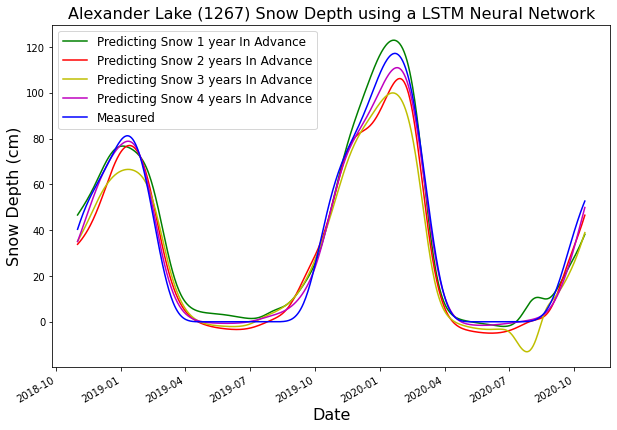

In [67]:
import matplotlib.pyplot as plt

test_size = int(round(len(Xs1) * 0.4, 0))  # Training data is 60% of data
# test_size = len(y_predict_unscaled4) # change to unscaled2 if using temp and prec
print(time_axis)
time_axis = time_axis[0:test_size]
print(time_axis)
y_predict_unscaled1 = y_predict_unscaled1[0:test_size]
y_predict_unscaled2 = y_predict_unscaled2[0:test_size]
y_predict_unscaled3 = y_predict_unscaled3[0:test_size]
y_predict_unscaled4 = y_predict_unscaled4[0:test_size]

y_train_unscaled = y_train_unscaled[0:test_size]

plt.figure(figsize=(10,7))
plt.plot(time_axis, y_predict_unscaled1, 'g-', label='Predicting Snow 1 year In Advance')
plt.plot(time_axis, y_predict_unscaled2, 'r-', label='Predicting Snow 2 years In Advance')
plt.plot(time_axis, y_predict_unscaled3, 'y-', label='Predicting Snow 3 years In Advance')
plt.plot(time_axis, y_predict_unscaled4, 'm-', label='Predicting Snow 4 years In Advance')

plt.plot(time_axis, y_train_unscaled, 'b-', label='Measured')
plt.legend(fontsize=12)
plt.ylabel('Snow Depth (cm)', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.gcf().autofmt_xdate()
plt.title(station_name + ' Snow Depth using a LSTM Neural Network', fontsize=16)

In [68]:
rms1 = mean_squared_error(y_train_unscaled, y_predict_unscaled1, squared=False)  # Calculating root mean squared error
rms2 = mean_squared_error(y_train_unscaled, y_predict_unscaled2, squared=False)  # Calculating root mean squared error
rms3 = mean_squared_error(y_train_unscaled, y_predict_unscaled3, squared=False)  # Calculating root mean squared error
rms4 = mean_squared_error(y_train_unscaled, y_predict_unscaled4, squared=False)  # Calculating root mean squared error

print('--------- Predicting Snow 1 year In Advance -------------')
print('average rms is ' + str(rms1))  # Calculating and printing mean rms
print('--------- Predicting Snow 2 years In Advance -------------')
print('average rms is ' + str(rms2))  # Calculating and printing mean rms
print('--------- Predicting Snow 3 years In Advance -------------')
print('average rms is ' + str(rms3))  # Calculating and printing mean rms
print('--------- Predicting Snow 4 years In Advance -------------')
print('average rms is ' + str(rms4))  # Calculating and printing mean rms

--------- Predicting Snow 1 year In Advance -------------
average rms is 6.029808967729425
--------- Predicting Snow 2 years In Advance -------------
average rms is 6.522371779081523
--------- Predicting Snow 3 years In Advance -------------
average rms is 8.881378295053239
--------- Predicting Snow 4 years In Advance -------------
average rms is 3.321351905173754
